# PSYCH253 project: decoding emotion and emotion regulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import h5py

In [2]:
from nilearn import plotting
from nilearn.image import mean_img
from nilearn import image
from nilearn.input_data import NiftiMasker

C:\ProgramData\Miniconda3\lib\site-packages\nilearn\plotting\cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)


In [3]:
import os

os.chdir('C:/Users/tepzh/Desktop/psych253 downloads/project')
print(os.getcwd())

C:\Users\tepzh\Desktop\psych253 downloads\project


### View sample anatomical and functional data

In [4]:
# subj_anat_path = 'sub-Spieg16034/anat/sub-Spieg16034_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
subj_anat_path = 'sub-Spieg16034/anat/sub-Spieg16034_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz'
# plotting.plot_img(subj_anat_path)
# plotting.plot_glass_brain(subj_anat_path)   
plotting.view_img(subj_anat_path, bg_img=False, #cmap=plt.get_cmap('gray'), 
                  threshold=None)

In [11]:
# create gray matter task
from nilearn.image import math_img

gm_img = 'sub-Spieg16034/anat/sub-Spieg16034_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz'
threshold = .5
mask = math_img(f'img > {threshold}', img=gm_img)
mask.to_filename('ROIs/gray_matter_example_mask.nii.gz')

# plotting.view_img(mask, bg_img=False, #cmap=plt.get_cmap('gray'), 
#                   threshold=None)

(97, 115, 97, 205)



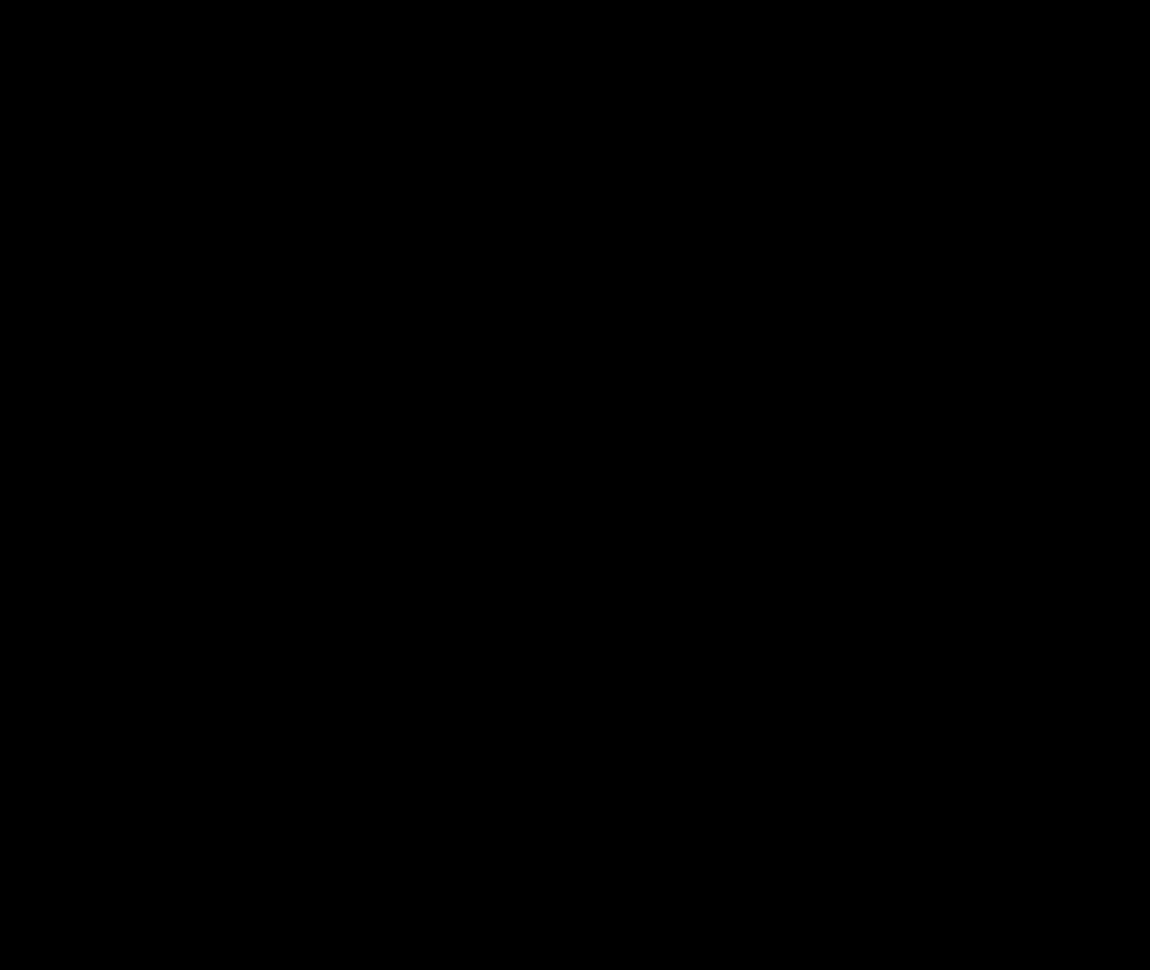
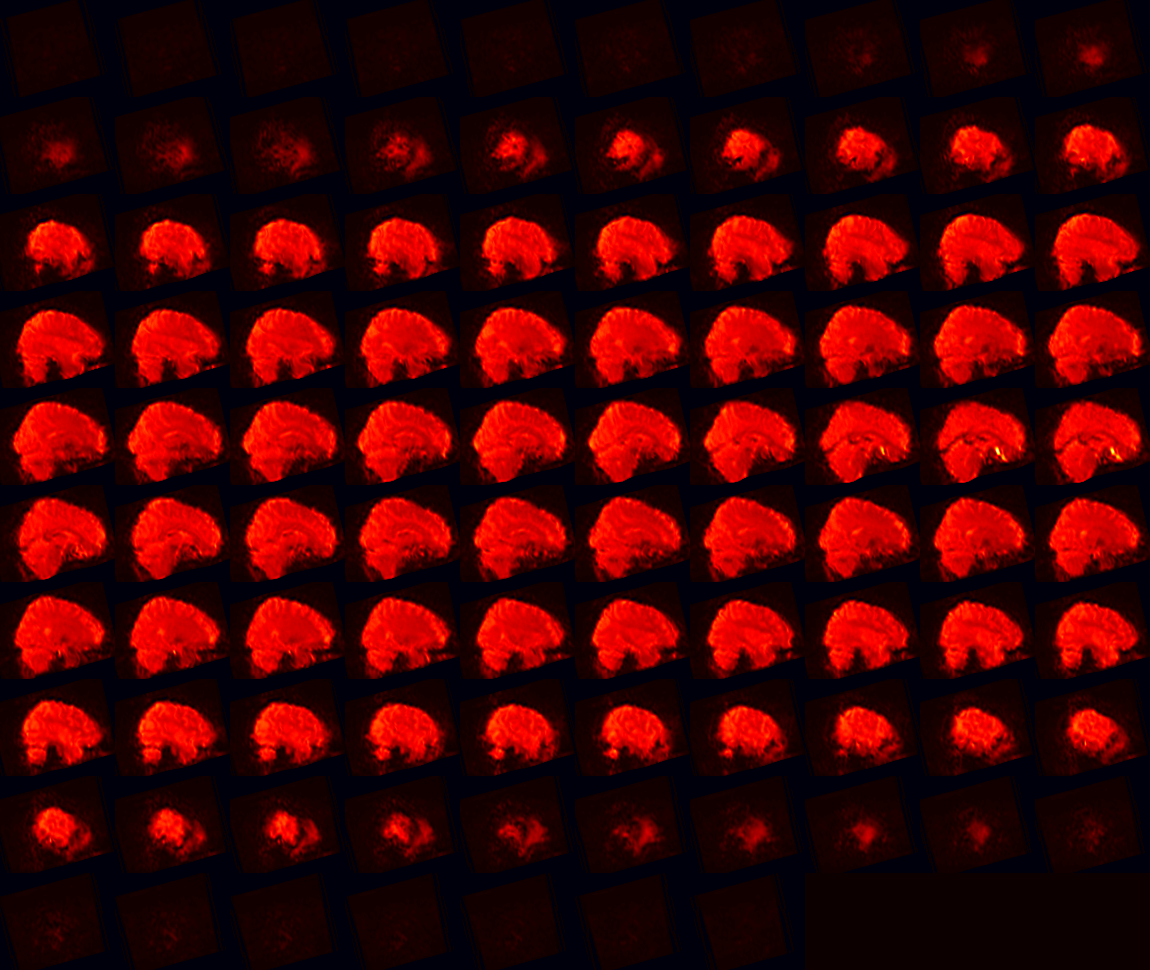

In [6]:
subj_func_path = 'sub-Spieg16034/func/'
run1_file = subj_func_path + 'sub-Spieg16034_task-ER_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

print(image.load_img(run1_file).shape)
plotting.view_img(mean_img(run1_file), 
                  bg_img=None,
                  threshold=None)

### Read and visualize sample functional data in a mask

In [155]:
mask_amy = 'ROIs/bilateral_Amygdala_mask.nii.gz'

masker_amy = NiftiMasker(mask_img=mask_amy, standardize=False, detrend=False)
fmri_run1_amy_masked = masker_amy.fit_transform(run1_file)
print(fmri_run1_amy_masked.shape)

# plotting.plot_roi(mask_amy)

plt.plot(fmri_run1_amy_masked[:, :20], alpha = .2)
# plt.plot(fmri_run1_amy_masked.mean(axis=1)[1:])

plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Raw signal')
plt.tight_layout()

In [171]:
mask_files = ['bilateral_Amygdala', 'anterior_cingulate', 'posterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus']
mask_short_name = ['amy', 'acc', 'pcc', 'fp', 'ifg']

for i in range(len(mask_files)):
    print('plotting', mask_files[i])
    mask = 'ROIs/' + mask_files[i] + '_mask.nii.gz'
    plotting.plot_roi(mask, output_file='figures/roi_' + mask_short_name[i] + '.png')


plotting bilateral_Amygdala
plotting anterior_cingulate
plotting posterior_cingulate
plotting frontal_pole
plotting inferior_frontal_gyrus


In [42]:
n_volumes = fmri_run1_amy_masked.shape[0]
n_events = df_run1_events.shape[0]

trial_type = ['no_event']*n_volumes
trial_time = ['']*n_volumes
trial_idx = ['']*n_volumes
for i in range(n_volumes):
    for j in range(n_events):
        if i>df_run1_events['min_volume'][j] and i<df_run1_events['max_volume'][j]:
            trial_type[i] = df_run1_events['trial_type'][j]
            trial_time[i] = (i - df_run1_events['min_volume'][j])*2
            trial_idx[i] = j
            
df_run_info = pd.DataFrame({'type': trial_type,'trial': trial_idx, 'time': trial_time})
df_run_info

type trial   time
0          no_event             
1          no_event             
2          no_event             
3    negative-react     0  1.902
4    negative-react     0  3.902
..              ...   ...    ...
200        no_event             
201        no_event             
202        no_event             
203        no_event             
204        no_event             

[205 rows x 3 columns]

### Read real functional data in masks

In [4]:
# read nifti data of 1 run
def read_and_convert_fmri_run_data(subject, mask, run_num, trial_start_time=2, trial_end_time=14):
    """
    read fmri data of voxels in a mask of 1 run of 1 subject and convert them into a numpy array
    
    arguments:
        subject: subject ID 
        mask: mask name, options are 'bilateral_Amygdala', 'anterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus',
        'insula', 'mPFC', 'OFC', 'posterior_cingulate'
        run_num: run number, usually 1 to 5
        trial_start_time: for each trial, the start time (in seconds) you want to extract data
        trial_end_time: for each trial, the end time (inseconds) you want to extract data
        
    returns:
        a dict of 'data' (numpy array of shape (m, n) where m is the number of trials and n is the number of voxels in this mask) 
            and 'label' (a numpy array of shape (m,) where m is the number of trials; 
            the value being the type of each trial: neutral, negative-react, negative-regulate)
    """
    print('run', run_num, '...')
    subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
    run_file = subj_func_path + 'sub-Spieg' + str(subject) + '_task-ER_run-' + str(run_num) + \
                '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    
    # read confounds
    if False:
        confounds_file = subj_func_path + 'sub-Spieg' + str(subject) + '_task-ER_run-' + str(run_num) +\
                        '_desc-confounds_regressors.tsv'
        confounds = pd.read_csv(confounds_file, sep='\t')
        confounds['framewise_displacement'][0] = 0
        # select confounds
        confounds = confounds[['framewise_displacement']]
        confounds = np.array(confounds)
    else:
        confounds = None
    
    # masker
    mask_file = 'ROIs/' + mask +'_mask.nii.gz'
    masker = NiftiMasker(mask_img=mask_file, standardize=False, detrend=False)
    fmri_run_masked = masker.fit_transform(run_file, confounds=confounds)    
    n_volumes = fmri_run_masked.shape[0]
    
    run_events = subj_func_path + 'run' + str(run_num)+ '_picture.csv'
    df_run_events = pd.read_csv(run_events)
    n_events = df_run_events.shape[0]
    df_run_events['trial_type'] = df_run_events['condition'].replace({'wat_ntr':'neutral', 
                                                                      'wat_IAPS_neg':'negative-react',  
                                                                      'wat_BC_neg':'negative-react', 
                                                                      'reap_IAPS_neg':'negative-regulate', 
                                                                      'reap_BC_neg':'negative-regulate'})
    # per trial: data from t = 2 to 16
    df_run_events['min_volume'] = (df_run_events['picture_time'] )/2
    df_run_events['max_volume'] = (df_run_events['picture_time'] + 16)/2    
    
    
#     # label data for each volume
#     trial_type = ['no_event']*n_volumes
#     trial_time = ['']*n_volumes
#     trial_idx = ['']*n_volumes
#     for i in range(n_volumes):
#         for j in range(n_events):
#             if i>df_run_events['min_volume'][j] and i<df_run_events['max_volume'][j]:
#                 trial_type[i] = df_run_events['trial_type'][j]
#                 trial_time[i] = (i - df_run_events['min_volume'][j])*2
#                 trial_idx[i] = j
#     df_run_info = pd.DataFrame({'type': trial_type,'trial': trial_idx, 'time': trial_time})
    
    
    run_trial_level = []
    for j in range(n_events):
        min_volume = df_run_events['min_volume'][j] + trial_start_time/2
        max_volume = df_run_events['min_volume'][j] + trial_end_time/2
        min_volume = int(np.ceil(min_volume))
        max_volume = int(np.ceil(max_volume))
#         print('event', j, 'volume:', min_volume, '-', max_volume)

        data_this_trial = fmri_run_masked[min_volume:max_volume].mean(axis = 0)
        run_trial_level.append(data_this_trial)

    run_trial_level = np.array(run_trial_level)
    # standardize data across voxels
    run_trial_level = stats.zscore(run_trial_level, axis = 0)
    
    results = {'data': run_trial_level, 'label': np.array(df_run_events['trial_type'])}
    
    return results


# read nifti data of multiple runs of 1 subject
def read_and_convert_fmri_subject_data(subject, mask, runs = 'all', 
                                       trial_start_time = 2, trial_end_time = 14, normalize = True):
    """
    read fmri data of voxels in a mask of multiple runs of 1 subject and convert them into a numpy array
    
    arguments:
        subject: subject ID 
        mask: mask name, options are 'bilateral_Amygdala', 'anterior_cingulate', 'frontal_pole', 'inferior_frontal_gyrus',
        'insula', 'mPFC', 'OFC', 'posterior_cingulate'
        runs: run numbers to extract data from; if 'all', extract all available runs
        trial_start_time: for each trial, the start time (in seconds) you want to extract data
        trial_end_time: for each trial, the end time (inseconds) you want to extract data
        normalize: whether to z-score data across voxels (observation-wise)
        
    returns:
        a dict of:
            'data' (numpy array of shape (m, n) where m is the number of trials and n is the number of voxels in this mask) 
            'label' (an array of shape (m,) where m is the number of trials; the value being the type of each trial: neutral, negative-react, negative-regulate)
            'run' (an array of shape (m,) indicating the run number of each trial)
    """    
    import glob
    
    print("processing", subject)
    if runs == 'all':
        subj_func_path = 'sub-Spieg'+ str(subject) + '/func/'
        max_run = len(glob.glob(subj_func_path + 'run[0-9]_picture.csv'))
        runs = list(range(1, max_run + 1))
#         print(runs)
    
    subject_results =  {'data':[], 'label':[], 'run':[]}
    first_run = True
    for run in runs:
        run_results = read_and_convert_fmri_run_data(subject, mask, run, trial_start_time, trial_end_time)
        subject_results['data'].append(run_results['data'])
        subject_results['label'].extend(run_results['label'])
        subject_results['run'].extend([run] * (np.shape(run_results['data'])[0]))
#         print(np.shape(subject_results['data']))
    
    subject_results['data'] = np.array(subject_results['data'])
    # convert data from 3D to 2D array ((5, 23, 494) to (115, 494))
    subject_results['data'] = subject_results['data'].reshape((-1, subject_results['data'].shape[2]))
    if normalize:
        subject_results['data'] = stats.zscore(subject_results['data'], axis = 1)
    print('data shape:', np.shape(subject_results['data']))
    return subject_results

In [173]:
# # read data of 16034
# data_sub_16034_amy = read_and_convert_fmri_subject_data(16034, mask = 'bilateral_Amygdala')
# data_sub_16034_acc = read_and_convert_fmri_subject_data(16034, mask = 'anterior_cingulate')
# data_sub_16034_pcc = read_and_convert_fmri_subject_data(16034, mask = 'posterior_cingulate')
# data_sub_16034_insula = read_and_convert_fmri_subject_data(16034, mask = 'insula')
# data_sub_16034_ifg = read_and_convert_fmri_subject_data(16034, mask = 'inferior_frontal_gyrus')
# data_sub_16034_fp = read_and_convert_fmri_subject_data(16034, mask = 'frontal_pole')
# data_sub_16034_mpfc = read_and_convert_fmri_subject_data(16034, mask = 'mPFC')
# data_sub_16034_ofc = read_and_convert_fmri_subject_data(16034, mask = 'OFC')
# data_sub_16034_cingulate = read_and_convert_fmri_subject_data(16034, mask = 'cingulate')

masks = ['amy', 'acc', 'pcc', 'insula', 'ifg', 'fp', 'mpfc', 'ofc', 'cingulate']
# for mask in masks:
#     np.savetxt('sub-Spieg16034/func/data_' + mask + '.txt', eval('data_sub_16034_' + mask)['data'])

# data_sub_16034_amy = {}
# data_sub_16034_acc = {}
# data_sub_16034_pcc = {}
# data_sub_16034_insula = {}
# data_sub_16034_ifg = {}
# data_sub_16034_fp = {}
# data_sub_16034_mpfc = {}
# data_sub_16034_ofc = {}
# data_sub_16034_cingulate = {}

for mask in masks:
#     eval('data_sub_16034_' + mask)['data'] = np.loadtxt('sub-Spieg16034/func/data_' + mask + '.txt')
    print(mask + ':', eval('data_sub_16034_' + mask)['data'].shape)

processing 16034
run 1 ...
run 2 ...
run 3 ...
run 4 ...
run 5 ...
data shape: (115, 241)
amy: (115, 494)
acc: (115, 1496)
pcc: (115, 1251)
insula: (115, 1622)
ifg: (115, 241)
fp: (115, 9691)
mpfc: (115, 540)
ofc: (115, 1591)
cingulate: (115, 2747)


In [67]:
# h5py start guide
# http://docs.h5py.org/en/stable/quick.html
# https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html

# meta_sub_16034 = {}
# meta_sub_16034['label'] = data_sub_16034_ifg['label']
# meta_sub_16034['run'] = data_sub_16034_ifg['run']

# ????? need to look more into how h5py works
with h5py.File("sub-Spieg16034/func/ROI_data.hdf5", "r+") as data_sub_16034:
    metadata = data_sub_16034.create_group('metadata')
    metadata.create_dataset("label", np.array(meta_sub_16034['label'], dtype='S'))
    metadata.create_dataset("run", np.array(meta_sub_16034['run']))

# print(data_sub_16034['metadata'])
# for k, v in d.items():
#     h.create_dataset(k.strftime('%Y-%m-%dT%H:%M:%SZ'), data=np.array(v, dtype=np.int8))

ValueError: Dimensionality is too large (dimensionality is too large)

In [298]:
data_sub_16034 = {}
data_sub_16034['label'] = data_sub_16034_amy['label'] 
data_sub_16034['run'] = data_sub_16034_amy['run'] 
data_sub_16034['data'] = np.concatenate((data_sub_16034_pcc['data'], data_sub_16034_acc['data']), axis = 1)
# data_sub_16034['data'] = data_sub_16034_pcc['data']

print('data shape:', np.shape(data_sub_16034['data']))

data shape: (115, 2747)


In [170]:
print(data_sub_16034['label'])
print(data_sub_16034['run'])

['negative-react', 'neutral', 'neutral', 'negative-react', 'neutral', 'neutral', 'negative-react', 'negative-react', 'negative-regulate', 'negative-regulate', 'negative-regulate', 'negative-regulate', 'negative-react', 'neutral', 'negative-react', 'neutral', 'negative-regulate', 'neutral', 'negative-react', 'negative-regulate', 'negative-react', 'negative-regulate', 'negative-regulate', 'negative-react', 'negative-react', 'negative-react', 'negative-regulate', 'negative-react', 'neutral', 'neutral', 'negative-react', 'neutral', 'negative-regulate', 'negative-react', 'negative-react', 'negative-react', 'neutral', 'negative-regulate', 'negative-regulate', 'neutral', 'negative-regulate', 'negative-regulate', 'neutral', 'neutral', 'negative-regulate', 'negative-regulate', 'neutral', 'neutral', 'negative-regulate', 'negative-react', 'negative-react', 'negative-regulate', 'neutral', 'negative-regulate', 'neutral', 'negative-react', 'negative-react', 'negative-regulate', 'negative-react', 'ne

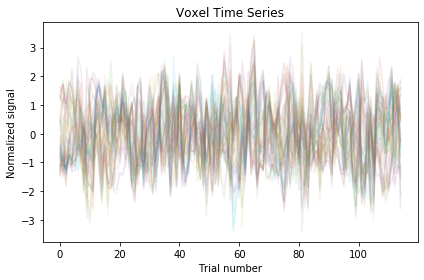

In [176]:
# visualize data of 16034
plt.plot(data_sub_16034_amy['data'][:, :50], alpha = .1)
# plt.plot(data_sub_16034['data'][:, -50:], alpha = .1)

plt.title('Voxel Time Series')
plt.xlabel('Trial number')
plt.ylabel('Normalized signal')
plt.tight_layout()

plt.savefig('figures/data_time_series_amy.png', dpi = 200)

In [69]:
from sklearn.decomposition import PCA as sklearn_PCA

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


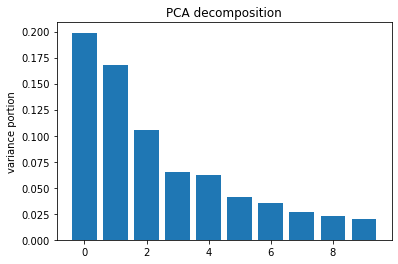

In [153]:
# eigen values
cov_mat = np.dot(data_sub_16034_amy['data'].T, data_sub_16034_amy['data'])
eig_vals = np.linalg.eigvals(cov_mat)
# print(eig_vals)

eig_vals_to_plot = eig_vals[:10] / np.sum(eig_vals)
y_pos = np.arange(len(eig_vals_to_plot))
plt.bar(y_pos, eig_vals_to_plot, align='center')
plt.ylabel('variance portion')
plt.title('PCA decomposition')
# plt.show()

plt.savefig('figures/eig_vals_amy.png', dpi = 200)

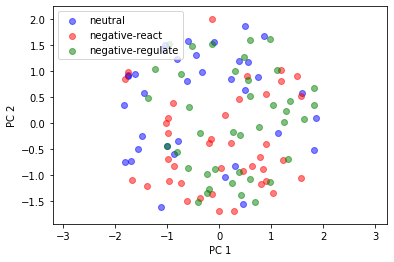

In [129]:
# PCA
cls = sklearn_PCA(n_components=3, whiten=True)
cls.fit(data_sub_16034_amy['data'])

Xproj = cls.transform(data_sub_16034_amy['data'])

category_subset = np.array(data_sub_16034_ifg['label'])
cat1 = 'neutral'
cat2 = 'negative-react'
cat3 = 'negative-regulate'

x = Xproj[:, 0]
y = Xproj[:, 1]
z = Xproj[:, 2]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
zb = z[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
zc = z[category_subset == cat2]
xd = x[category_subset == cat3]
yd = y[category_subset == cat3]
zd = z[category_subset == cat3]

plt.scatter(xb, yb, color='b', label=cat1, alpha = .5)
plt.scatter(xc, yc, color='r', label=cat2, alpha = .5)
plt.scatter(xd, yd, color='g', label=cat3, alpha = .5)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'upper left')

plt.savefig('figures/2d_visualization_amy.png', dpi = 200)

# # 3D plot
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# plt.scatter(xb, yb, zb, color='b', label=cat1, marker='o')
# plt.scatter(xc, yc, zc, color='r', label=cat2, marker='o')
# plt.scatter(xd, yd, zd, color='g', label=cat3, marker='o')
# ax.set_xlabel('PC 1')
# ax.set_ylabel('PC 2')
# ax.set_zlabel('PC 3')

# plt.show()

### SVM classifier

In [53]:
# get meta data
meta_sub_16034 = {}
meta_sub_16034['label'] = data_sub_16034['label']
meta_sub_16034['run'] = data_sub_16034['run']

meta_array = np.core.records.fromarrays(meta_sub_16034.values(), 
                                        names=list(meta_sub_16034.keys())[0] + ',' +list(meta_sub_16034.keys())[1])
meta_array.dtype.names
# print(list(meta_sub_16034.keys())[0])

('label', 'run')

In [137]:
def get_splits(metadata,
               split_by_func,
               num_splits,
               num_per_class_test,
               num_per_class_train,
               train_filter=None,
               test_filter=None,
               seed=0):
    """
    construct a consistent set of splits for cross validation
    
    arguments: 
        metadata: numpy.rec.array of metadata 
        split_by_func: callable, returns label for spliting data into balanced categories 
                       when applied to metadata
        num_per_class_test: number of testing examples for each unique 
                            split_by category
        num_per_class_train: number of train examples for each unique 
                            split_by category
        train_filter: callable (or None): specifying which subset of the data 
                 to use in training applied on a per-element basis to metadata
        test_filter: callable (or None): specifying which subset of the data 
                 to use in testing applied on a per-element basis to metadata
        seed: seed for random number generator
    """
    
    #define helper function for filtering metadata by desired filter
    def get_possible_inds(metadata, filter):
        inds = np.arange(len(metadata))
        if filter is not None:
            subset = np.array(map(filter, metadata)).astype(np.bool)
            inds = inds[subset]
        return inds
    
    #filter the data by train and test filters
    train_inds = get_possible_inds(metadata, train_filter)
    test_inds = get_possible_inds(metadata, test_filter)
    
    #construct possibly category labels for balancing data
    labels = split_by_func(metadata)
    #for later convenience, get unique values of splitting labels in train and test data
    unique_train_labels = np.unique(labels[train_inds])
    unique_test_labels = np.unique(labels[test_inds])
    
    #seed the random number generator
    rng = np.random.RandomState(seed=seed)
    
    #construct the splits one by one
    splits = []
    for _split_ind in range(num_splits):
        #first construct the testing data
        actual_test_inds = []
        #for each possible test label
        for label in unique_test_labels: 
            #look at all possible stimuli with this label
            possible_test_inds_this_label = test_inds[labels[test_inds] == label]
            #count how many there are
            num_possible_test_inds_this_label = len(possible_test_inds_this_label)
            #make sure there are enough
            err_msg = 'You requested %s per test class but there are only %d available' % (
                    num_per_class_test, num_possible_test_inds_this_label)
            assert num_possible_test_inds_this_label >= num_per_class_test, err_msg
            #select num_per_class_test random examples
            perm = rng.permutation(num_possible_test_inds_this_label)
            actual_test_inds_this_label = possible_test_inds_this_label[
                                                      perm[ :num_per_class_test]]
            actual_test_inds.extend(actual_test_inds_this_label)
        actual_test_inds = np.sort(actual_test_inds)
        
        #now, since the pools of possible train and test data overlap, 
        #but since we don't want the actual train and data examples to overlap at all,
        #remove the chosen test examples for this split from the pool of possible 
        #train examples for this split
        remaining_available_train_inds = np.unique(list(set(
                           train_inds).difference(actual_test_inds)))
        
        #now contruct the train portion of the split
        #basically the same way as for the testing examples
        actual_train_inds = []
        for label in unique_train_labels:
            _this_label = labels[remaining_available_train_inds] == label
            possible_train_inds_this_label = remaining_available_train_inds[_this_label]
            num_possible_train_inds_this_label = len(possible_train_inds_this_label)
            err_msg = 'You requested %s per train class but there are only %d available' % (
                  num_per_class_train, num_possible_train_inds_this_label)
            assert num_possible_train_inds_this_label >= num_per_class_train, err_msg
            perm = rng.permutation(num_possible_train_inds_this_label)
            actual_train_inds_this_label = possible_train_inds_this_label[
                                                      perm[ :num_per_class_train]]
            actual_train_inds.extend(actual_train_inds_this_label)
        actual_train_inds = np.sort(actual_train_inds)
        
        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits


def validate_splits(splits, labels):
    train_classes = np.unique(labels[splits[0]['train']])
    for split in splits:
        train_inds = split['train']
        test_inds = split['test']
        assert set(train_inds).intersection(test_inds) == set([])
        train_labels = labels[split['train']]
        test_labels = labels[split['test']]
        assert (np.unique(train_labels) == train_classes).all()
        assert set(test_labels) <= set(train_classes)
    return train_classes

def featurewise_norm(data, fmean=None, fvar=None):
    """perform a whitening-like normalization operation on the data, feature-wise
       Assumes data = (K, M) matrix where K = number of stimuli and M = number of features
    """
    if fmean is None:
        fmean = data.mean(0)
    if fvar is None:
        fvar = data.std(0)
    data = data - fmean  #subtract the feature-wise mean of the data
    data = data / np.maximum(fvar, 1e-5)  #divide by the feature-wise std of the data
    return data, fmean, fvar

def visualize_confmat(cmat, ucats, fig=None):
    cmat = cmat.astype(float) / cmat.sum(0)
    plt.figure(figsize=(8, 6))
    if fig is None:
        plt.matshow(cmat, fignum=1)
    else:
        fig.gca().matshow(cmat, fignum=1)
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            plt.text(j-.1, i, '%.2f%%' % (cmat[i, j] * 100), color='w')
    M = len(ucats)
    plt.xticks(np.arange(M), ucats)
    plt.yticks(np.arange(M), ucats)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [55]:
from sklearn.model_selection import GridSearchCV
import metrics 

def train_and_test_scikit_classifier(features, 
                                     labels,
                                     splits,
                                     model_class,
                                     model_args=None,
                                     gridcv_params=None,                                     
                                     feature_norm=True,
                                     return_models=False,
                                     select_feature=True,
                                    ):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           model_class: the actual live pythone object that is the classifier "class" object
           model_args: dictionary of arguments for instantiating the classifier class obejct
           gridcv_params: dictionary of params for applying gridSearch cross-validation to
           feature_norm: apply featurewise_norm
           return_models: return actual trained models for each split
           select_feature: whether to select 100 most predictive features based on correlation in train data
           
       Returns:
           dictionary summary of training and testing results
    
    """
    train_confmats = []
    test_confmats = []
    
    if model_args is None:
        model_args = {}
    
    training_sidedata = []
    train_classes = validate_splits(splits, labels)
    
    models = []
    
    for split in splits:

        #here we instantiate the general classifier, whatever it is    
        model = model_class(**model_args)
    
        if gridcv_params is not None:
            model = GridSearchCV(model, gridcv_params)

        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]
        
        if select_feature:
            label1 =(np.array(train_labels) == 'neutral')
            label2 =(np.array(train_labels) == 'negative-react')
            label3 =(np.array(train_labels) == 'negative-regulate')

            cor_label1 = np.array([stats.pearsonr(train_features[:, i], label1)[0] 
                                         for i in range(train_features.shape[1])])
            cor_label2 = np.array([stats.pearsonr(train_features[:, i], label2)[0] 
                                         for i in range(train_features.shape[1])])
            cor_label3 = np.array([stats.pearsonr(train_features[:, i], label3)[0] 
                                         for i in range(train_features.shape[1])])

            # get the idx of 100 largest voxels
            idx_best_vox1 = np.argsort(np.absolute(cor_label1))[-100:]
            idx_best_vox2 = np.argsort(np.absolute(cor_label2))[-100:]
            idx_best_vox3 = np.argsort(np.absolute(cor_label3))[-100:]
            idx_best_vox = np.append(idx_best_vox1, [idx_best_vox2, idx_best_vox3])
            idx_best_vox_unique = np.unique(idx_best_vox)
            
            train_features = train_features[:, idx_best_vox_unique]
            test_features = test_features[:, idx_best_vox_unique]

        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        
        model.fit(train_features, train_labels)
        classes_ = model.classes_
        assert set(model.classes_) == set(train_classes)
        sidedata['classes_'] = classes_
        
        train_predictions = model.predict(train_features)
        train_confmat = metrics.get_confusion_matrix(train_predictions, 
                                                     train_labels, 
                                                     train_classes)
        train_confmats.append(train_confmat)
                
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
            
        test_predictions = model.predict(test_features)
        test_confmat = metrics.get_confusion_matrix(test_predictions, test_labels, train_classes)
        test_confmats.append(test_confmat)
        
        if return_models:
            models.append(model)
        
    train_confmats = np.array(train_confmats)
    train_results = metrics.evaluate_results(train_confmats, train_classes)
    test_confmats = np.array(test_confmats)
    test_results = metrics.evaluate_results(test_confmats, train_classes)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results, train_classes

In [56]:
splits = get_splits(metadata=meta_array, 
                    split_by_func=lambda x: x['label'],  #we're balancing splits by object
                    num_splits=50, 
                    num_per_class_test=5, 
                    num_per_class_train=30, 
                   )

# print(splits)

In [169]:
from sklearn.svm import LinearSVC

results, train_classes = train_and_test_scikit_classifier(# features=np.concatenate((data_sub_16034_pcc['data'], 
#                                                                                    data_sub_16034_fp['data'], 
#                                                                                    data_sub_16034_ifg['data'], 
#                                                                                    data_sub_16034_ofc['data'], 
#                                                                                   data_sub_16034_acc['data']), axis = 1), 
                                                        features=data_sub_16034_pcc['data'],
                                                       labels=meta_array['label'],
                                                       splits=splits,
                                                       model_class=LinearSVC,
                                                       model_args={'C':1e-3}, # Regularization parameter
#                                                         gridcv_params={'C':[1e-2, 1e-1, 1, 1e1, 1e2]},
                                                        select_feature=False
                                          )

# print(results)
print('train accuracy:', results['train']['mean_accuracy'])
print('test accuracy:', results['test']['mean_accuracy'])
print('test d-prime:', results['test']['mean_dprime'])

train accuracy: 0.9804444444444443
test accuracy: 0.6653333333333333
test d-prime: [0.81644793 1.41864114 2.05544683]


In [ ]:

# frontal pole
# train accuracy: 1.0
# test accuracy: 0.7119999999999999
# test d-prime: [1.53382265 1.61870664 1.78158357]

# PCC
# train accuracy: 0.9804444444444443
# test accuracy: 0.6653333333333333
# test d-prime: [0.81644793 1.41864114 2.05544683]

# IFG
# train accuracy: 0.9273333333333335
# test accuracy: 0.5853333333333334
# test d-prime: [0.86255465 1.16982119 1.08192212]

# OFC
# train accuracy: 1.0
# test accuracy: 0.584
# test d-prime: [1.12241031 0.929085   1.02917049]

# ACC
# train accuracy: 0.9748888888888888
# test accuracy: 0.5453333333333333
# test d-prime: [0.45816609 1.22040147 0.93658042]

# insula
# train accuracy: 0.8608888888888888
# test accuracy: 0.5373333333333333
# test d-prime: [0.4352982  0.91777976 1.14702024]

# mPFC
# train accuracy: 0.9713333333333334
# test accuracy: 0.492
# test d-prime: [0.26000973 0.6831583  1.04366111]

# amygdala
# train accuracy: 0.802
# test accuracy: 0.47733333333333333
# test d-prime: [0.38094803 0.41302117 0.95500438]

# PCC + ACC
# train accuracy: 1.0
# test accuracy: 0.6813333333333332
# test d-prime: [0.8616756  1.65728515 1.99297054]

# PCC + frontal pole
# train accuracy: 1.0
# test accuracy: 0.7173333333333333
# test d-prime: [1.46229059 1.62608545 1.88993762]

# PCC + frontal pole + IFG
# train accuracy: 1.0
# test accuracy: 0.7293333333333333
# test d-prime: [1.57050857 1.72992731 1.86951458]

# PCC + frontal pole + IFG + OFC + ACC
# train accuracy: 1.0
# test accuracy: 0.7293333333333333
# test d-prime: [1.51906169 1.68944744 1.96560979]

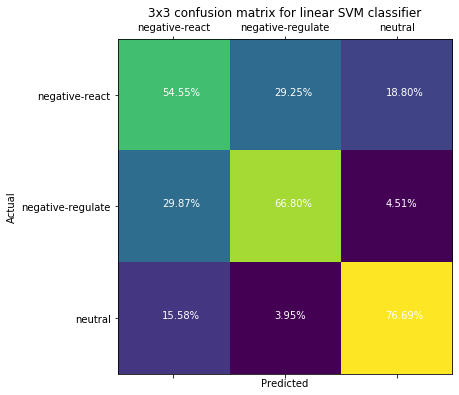

In [170]:
visualize_confmat(results['test']['confusion_matrices'].mean(0), 
                  results['test']['labels'])
plt.title('3x3 confusion matrix for linear SVM classifier')

plt.savefig('figures/confus_mat_pcc.png', dpi = 200)

### Correlation minimum distance classifier

In [63]:
import minimum_distance_classifier as mdc

results, train_classes = train_and_test_scikit_classifier(# features=np.concatenate((data_sub_16034_pcc['data'], data_sub_16034_fp['data']), axis = 1), 
                                                        features=data_sub_16034_ifg['data'],
                                           labels=meta_array['label'],
                                           splits=splits,
                                           model_class=mdc.MinimumDistanceClassifier,
                                            select_feature=True,
                                          )

print(results['train']['mean_accuracy'])
print(results['test']['mean_accuracy'])
print('test d-prime:', results['test']['mean_dprime'])

0.6233333333333333
0.47866666666666663
test d-prime: [0.30619033 0.90401167 0.60232969]


Text(0.5, 1.05, '3x3 confusion matrix for correlation distance classifier')

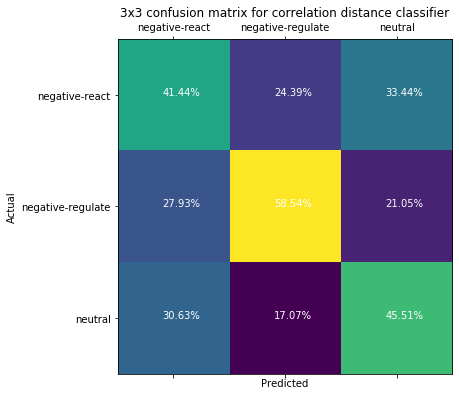

In [138]:
visualize_confmat(results['test']['confusion_matrices'].mean(0), 
                  results['test']['labels'])
plt.title('3x3 confusion matrix for correlation distance classifier')